In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
import numpy as np
import matplotlib
import lmfit
import emcee
import corner
import timeit
import os
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# function to draw a sample of events 
def draw_sample(df,weight_col='fwc'):
    # assumes weights are correct
    # norm is the sum of weights (i.e., expected number of detections)
    norm = np.sum(df[weight_col])
    # probabilities for individual events are equal to normalized weights
    probs = df[weight_col] / norm
    # the number of events drawn is a poisson draw of the expected number of events
    ndraw = np.random.poisson(lam=norm)
    # draw a random subset of events to be in the sample. Should replace be true?
    sample_idx = np.random.choice(df.shape[0],ndraw,replace=True,p=probs)
    # generate a data frame of the sample from the original data frame                                                                                                                                                                                                
    sample = df.iloc[sample_idx]
    return sample


# this function is used to determine if an event had time 'x' within a season. Right now it is hard coded 
# to the cycle 7 six season layout. The output value is negative if not in season and positive if in season. 
# The actual value corresponds to if which season (or after which season if negative)
def ssn(x):
        if np.isscalar(x):
                if x<112.5:
                        return 0
                if x<=184.5:
                        return 1
                if x<292.25:
                        return -1
                if x<=364.25:
                        return 2
                if x<477.75:
                        return -2
                if x<=549.75:
                        return 3
                if x<1388.0:
                        return -3
                if x<=1460.0:
                        return 4
                if x<1573.5:
                        return -4
                if x<=1645.5:
                        return 5
                if x<1753.25:
                        return -5
                if x<=1825.25:
                        return 6
                return -6
        else:
                ret = x*0+99
                ret[(ret==99) * (x<112.5)] = 0
                ret[(ret==99) * (x<=184.5)] = 1
                ret[(ret==99) * (x<292.25)] = -1
                ret[(ret==99) * (x<=364.25)] = 2
                ret[(ret==99) * (x<477.75)] = -2
                ret[(ret==99) * (x<=549.75)] = 3
                ret[(ret==99) * (x<1388.0)] = -3
                ret[(ret==99) * (x<=1460.0)] = 4
                ret[(ret==99) * (x<1573.5)] = -4
                ret[(ret==99) * (x<=1645.5)] = 5
                ret[(ret==99) * (x<1753.25)] = -5
                ret[(ret==99) * (x<=1825.25)] = 6
                ret[ret==99] = -6

                return ret
            

# a correction for the false positive fraction from Penny 2019            
def FPF(data,mearth,mass_col=42):
    alpha = 1.25
    beta = 2.7
    return (1+10**(alpha*np.log10(data['Planet_mass']/mearth)+beta))**-1

# for computing occurrence rates, 
def mass_func_arr(pars,planet_sample,mearth=3e-6):
    # compute the mass function values for a set of pars given a dataframe of events
    # this version is for a saturated power law in mass, single power law in SMA
    #logC, logMbreak, n, m = theta 
    try:
        M_planet = planet_sample['Planet_mass']/mearth
        sma = planet_sample['Planet_semimajoraxis']
    # this is to catch when an array of values (instead of data frame) is an argument, could be smarter
    except:
        M_planet = 10**planet_sample
        sma = np.ones(len(M_planet))
    
    # set up return array
    ret = np.ones(len(sma))
    
    
    # unpack the pars into a dict if in list form
    if type(pars) is list or type(pars) is np.ndarray:
        #starting_mean = np.array([logC1_start,logMbreak_start,logC2_start,logMS2_start,n2_start,m_start])                                                                                                             
        theta = {'logC':pars[0],
                 'n':pars[1],
                 'm':pars[2]}
    # else pars is already a dictionary
    else:
        theta=pars

    # compute rates
    ret = 10**theta['logC'] * (M_planet)**theta['n'] * sma**theta['m']
    return ret

# this function calculates the occurrence rate grid for a given set of parameters pars and grid points provided
# by m,a (which are likely log-uniform spaced log values)
def occ_arr(pars,m,a,mearth=3e-6):
    #logC, logMbreak, n, m = theta
    # delog the grid point values for mass func calcs
    M_planet = 10**m
    sma = 10**a
    # just making some arrays of ones
    m_vals = (M_planet/M_planet).copy() 
    s_vals = (sma/sma).copy()
    
    # unpack the pars into a dict if in list form
    if type(pars) is list or type(pars) is np.ndarray:
        theta = {'logC':pars[0],
                 'n':pars[1],
                 'm':pars[2]}                                                                                                                                                                                         
    else:
        theta=pars

    m_vals = 10**theta['logC'] * (M_planet)**theta['n']
    s_vals = sma**theta['m']
    return m_vals.reshape(1,-1)*s_vals.reshape(-1,1)

######## MCMC FUNCTIONS ########

def N_exp_real(theta,planet_sample,survey_sensitivity):
    # integrate the survey sensitivity to get the expected number of detections
    # these should be arguments, but left in for now
    a_low,a_high,m_low,m_high = 0.01,10.,0.01,10.
    nbins = survey_sensitivity.shape[0]+1
    # generate grid points to integrate over
    m_bins = np.linspace(np.log10(m_low),np.log10(m_high),nbins,endpoint=True)
    a_bins = np.linspace(np.log10(a_low),np.log10(a_high),nbins,endpoint=True)
    m_bin_centers = (m_bins[1:]+m_bins[:-1])/2
    a_bin_centers = (a_bins[1:]+a_bins[:-1])/2

    # make a 2d array of the expected number of detections given the occurrence rate parameters being proposed (theta)
    zz = occ_arr(theta,a_bin_centers.reshape(-1,1),m_bin_centers.reshape(1,-1))
    # integrate over the occurrence rate grid
    # the next line *SHOULD* work, it should just be a 2d integral. I haven't gotten a chance to retest it
    #int1 = scipy.integrate.simps([scipy.integrate.simps(zz_x,a_bin_centers) for zz_x in zz*survey_sensitivity],m_bin_centers)
    # split integral into two parts to clarify/test
    inner_int = np.array([scipy.integrate.simpson(row,x=a_bin_centers) for row in zz*survey_sensitivity])
    int1 = scipy.integrate.simpson(inner_int,x=m_bin_centers)
    # this is a short cut to "integrate" I think, just occurrence rate * sensitivity * bin size
    # int1 = np.sum(zz*survey_sensitivity)*(m_bins[1]-m_bins[0])*(a_bins[1]-a_bins[0])
    return int1

def N_exp_true(theta,planet_sample,det_full):
    # "integrate" the expected number of detections by just summing weights. This is a too-accurate method,
    # and the other should be preferred. Made for testing, and would need to be updated. 
    raww_col = 'final_weight'
    int_value = 9
    weights = mass_func_arr(theta,det_full)*det_full[raww_col]*int_value
    #print("Nexp: ",np.sum(weights))                                                                                                                                                                                   
    return np.sum(weights)


# calculate the negative log likelihood for minimization
def ln_like_neg(theta, planet_sample,survey_sensitivity):
    return -1*ln_like(theta, planet_sample,survey_sensitivity)

# calculate the log likelihood
def ln_like(theta, planet_sample,survey_sensitivity):                                                                                                                                                                                        
    #logA, logB, logM_br, logM_slope, n, p, m = theta 
    # evaluate the mass function at all planets in the sample  
    mass_func_vals = mass_func_arr(theta,planet_sample)
    # determine the number of expected detections
    # this should integrate over the survey sensitvity
    N_exp_1 = N_exp_real(theta,planet_sample,survey_sensitivity)
    # this version numerically determines the expected number of planets by just summing weights
    #N_exp_2 = N_exp_true(theta,planet_sample,sensitivity_sum,parameters_to_fit,det_full)                                                                                                                               
    #print('Nexp1, Nsamp :',N_exp_1, planet_sample.shape[0])
    # log likelihood summation. Recall that the individual sensitivities are stored in the first column, 
    # which is done in data processing.
    like_ = (-N_exp_1 + np.sum(np.log(mass_func_vals*planet_sample["sensitivity"])))
    
    return like_

def ln_prior(theta,paramters_to_fit=None):
    # prior ranges, right now just uniform priors. You will need to set these up for the 
    # variables being investigated, as well as suitable ranges
    if not np.log10(0.01) < theta[0] < np.log10(10):
        return -np.inf
    if not -2 < theta[1] < 2:
        return -np.inf
    if not -2 < theta[2] < 2:
        return -np.inf                                                                                                                                                                                       
    return 0.0

# natural log of probability
def ln_prob(theta, planet_sample, det_full):
    """
    combines likelihood and priors; returns ln(prob) 
    theta is an array of parameters for the mass function to be fit
    """
    # calculate the prior value given theta  
    ln_prior_ = ln_prior(theta) 
    # check that the prior did not go out of bounds; return negative infinity if it did
    if not np.isfinite(ln_prior_):
        return -np.inf
    # calculate the likelihood
    ln_like_ = ln_like(theta, planet_sample, det_full)

    # if for some reason likelihood is nan, return negative infinity, shouldn't happen and can probably be removed                                                                                                                                                                       
    if np.isnan(ln_like_):
        return -np.inf
    # multiply the prior and the lkikelihood
    ln_prob_ = ln_prior_ + ln_like_
    # return the probability, what emcee expects
    return ln_prob_ 


######## SET-UP FUNCTIONS ########

# integrate modified cassan mass function (saturated at m=5.2mearth)
def integrate_cassan(a_low,a_high,m_low,m_high):
    #earht masses                                                                                                                                                                                                      
    a_int = (np.log(a_high)-np.log(a_low))/np.log(10)

    if m_low > 5.2:
        m_int = -4.06524/(m_high**(0.74)) + 4.06524/(m_low**(0.74))
        return (a_int*m_int)
    else:
        m_int_low = 2*(np.log(5.2)-np.log(m_low))/np.log(10)
        m_int_high = -4.06524/(m_high**(0.74)) + 4.06524/(5.2**(0.74))
        return (m_int_low+m_int_high)*a_int

# calculate integral of a log uniform distribution. Limits are log values of bounds
def integrate_loguniform(a_low,a_high,m_low,m_high):
    return (np.log10(a_high)-np.log10(a_low)) * (np.log10(m_high)-np.log10(m_low))

def calc_weights(df,event_rate_weight=1,int_func=integrate_loguniform,raww_col='final_weight'):
    #get the cassan integral                                                                                                                                                                                           
    int_value = int_func(a_low,a_high,a_low,a_high)
    #for all events, calculate the cassan weight                                                                                                                                                                       
    weight = cassan(data)
    new_weights = df[raww_col]*cassan(data)*int_value*event_rate_weight
    return new_weights

# function to generate the individual sensitivities for an event given a survey sensitivity
def get_2dhist_values(grid,sample,a_bins,m_bins):
    mass_col = 'Planet_mass'
    a_col = 'Planet_semimajoraxis'
    a_bin_centers = ((a_bins[:-1]+a_bins[1:])/2)
    m_bin_centers = a_bin_centers
    mearth = 3.00374072e-6

    sensitivities = []

    for index, planet in sample.iterrows():
        #print('here')
        #print(planet,planet[mass_col])
        m_ind = np.abs(m_bin_centers - np.log10(planet[mass_col]/mearth)).argmin()
        a_ind = np.abs(a_bin_centers - np.log10(planet[a_col])).argmin()
        #XXXensure these are correctly indexed                                                                                                                                                                         
        sensitivities.append(grid[a_ind,m_ind])

    return sensitivities



# apply specific cuts to the data. Default values are for essentially the nomnial detection threshold of planets
def apply_cuts(dataFrame,flatchi2=500,chi2=160,u0max=3,t0inseason=True,noFS=False):
    dat = dataFrame.copy()
    # apply single lens chi2 cut - deafult is 500 above a flat light curve fit
    dat = dat[dat['ObsGroup_0_flatchi2']>=flatchi2]
    # apply binary lens cut - default is 160 above single lens fits
    dat = dat[dat['ObsGroup_0_chi2']>=chi2]
    # apply u0max cut- default is 3
    dat = dat[np.abs(dat['u0lens1'])<u0max]
    # apply inseasoncut
    if t0inseason:
        dat = dat[dat['ssn0']>0]
    # apply no finite source cut
    if noFS:
        dat=dat[dat['ObsGroup_0_FiniteSourceflag']==0]
    return dat

In [3]:
# definitions   
# Mass of Earth 
mearth = 3.00374072e-6
# limits for sma and mass bins, needs to match injected planet distribution
a_low,a_high,m_low,m_high = 0.01,10.,0.01,10.
# number of bins  
nbins = 20
# make bin edges for mass-sma grid   
m_bins = np.linspace(np.log10(m_low),np.log10(m_high),nbins,endpoint=True)
a_bins = np.linspace(np.log10(a_low),np.log10(a_high),nbins,endpoint=True)
m_bin_centers = (m_bins[1:]+m_bins[:-1])/2tree?
a_bin_centers = (a_bins[1:]+a_bins[:-1])/2

Object `tree` not found.


In [4]:
# read in all events
column_names = ['Lens_Mbol', 't0lens1', 'tcroin', 'u0lens1', 'ObsGroup_0_chi2', 'ObsGroup_0_flatchi2', 'ObsGroup_0_FiniteSourceflag', 'Lens_b', 'Lens_l', 'Field',
                'Planet_semimajoraxis', 'Planet_mass', 'Planet_q',
                'final_weight'
               ]
#filename = '/fs/project/gaudi.1/crisp/gulls/romanc7_hz_simple/analysis/romanc7_hz_simple.out.hdf5'
filename = '/fs/project/gaudi.1/crisp/gulls/romanc7_hz_simple/analysis.real/romanc7_hz_simple.out.hdf5'
tot = pd.read_hdf(filename, columns=column_names)

In [5]:
# perform some calculations to append some columns that we will need
# first is insolation
tot['Planet_insolation'] = 10**(0.4*(4.74-tot['Lens_Mbol'])) * (tot['Planet_semimajoraxis'])**-2
# add a column indicating if t0 occurred in season
tot['ssn0'] = ssn(tot['t0lens1'])

/tmp/slurmtmp.8740314/ipykernel_3322162/2904482551.py:49: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  ret[(ret==99) * (x<112.5)] = 0
/tmp/slurmtmp.8740314/ipykernel_3322162/2904482551.py:50: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  ret[(ret==99) * (x<=184.5)] = 1
/tmp/slurmtmp.8740314/ipykernel_3322162/2904482551.py:51: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  ret[(ret==99) * (x<292.25)] = -1
/tmp/slurmtmp.8740314/ipykernel_3322162/2904482551.py:52: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  ret[(ret==99) * (x<=364.25)] = 2
/tmp/slurmtmp.8740314/ipykernel_3322162/2904482551.py:53: UserWarning: evaluating in Python space because the '

In [6]:
#### Apply covering factor ####
# This goes through and multiplies each event for the fraction of the subfield it was drawn from
# that is covered by a given survey footprint.
# Also apply corr for log-uniform planet injection
tot['fwc'] = tot['final_weight']
# Also, there is a false positive fraction (FPF) that can be accounted for from Penny 2019
#dat['final_weight'] *= (1 - FPF(dat,mearth))
covfac = pd.read_csv('/home/crisp.92/Programs/gulls/scripts/covfac/layout7f.approx.covfac',index_col='ID_src')
# I cannot remember why this is here.
print(covfac.loc[2669].reset_index())
# Running sum of the covering factor, adds together each unique covfac number and multiplies by
# the subfield size to calculate the area of the survey footprint. Just a sanity check. 
cov_sum = 0
# for each unique field of events
for field in np.unique(tot['Field']):
    # generate a mask for events that were drawn from that field
    mask = tot['Field'] == field
    # This scale factor should probably be elsewhere. WRITE DETAILS
    # Essentially just renormalizes the event rates to be "one per star per mass per SMA bin"
    scalefac = 1 
    # This creates a new final weight corrected (fwc) column
    tot.loc[mask,'final_weight'] = scalefac * covfac.loc[field]['covfac'] * tot.loc[mask]['final_weight']
    # update running covfac sum
    cov_sum += covfac.loc[field]['covfac']*.2*.2
    # print number of events, the field number, and the covfac value
    #print(tot.loc[mask,'final_weight'].shape,field,covfac.loc[field]['covfac'])
# print survey area from covfac calc
print(cov_sum)

    index  2669
0       l  -5.0
1       b  -4.0
2  covfac   0.0
1.8931712961709124


In [7]:
# filter tot for only events with t0 in season
# dat is essentially single lens detected events with t0inSeason
dat = apply_cuts(tot,flatchi2=500, chi2=-1e9)
# det is detected planets with t0inSeason
det = apply_cuts(tot,flatchi2=500, chi2=160)

-2.2057731 -0.39435861
5.2688221e-09 360.0


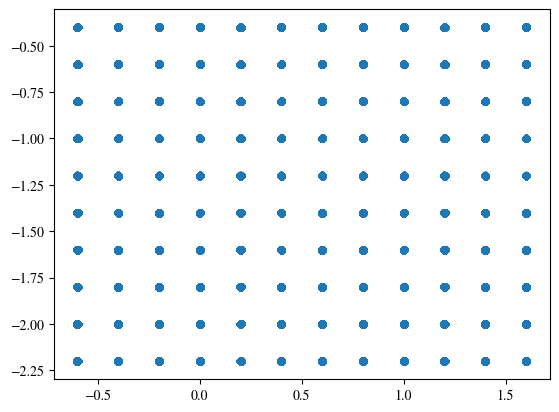

In [8]:
# Just make a plot of field extents more less, not important
print(np.min(dat['Lens_b']),np.max(dat['Lens_b']))
print(np.min(dat['Lens_l']),np.max(dat['Lens_l']))
dat.loc[dat['Lens_l']>300,'Lens_l'] = dat[dat['Lens_l']>300]['Lens_l'] - 360
plt.plot(dat['Lens_l'],dat['Lens_b'],'.')

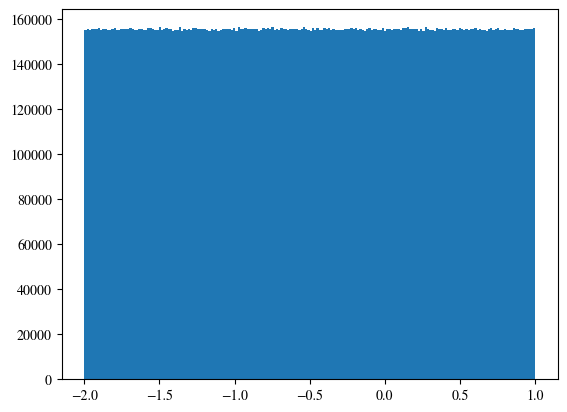

In [9]:
# plot the distribution of SMA
plt.hist(np.log10(tot['Planet_semimajoraxis']),bins=200)#,weights=det['fwc'])
plt.show()

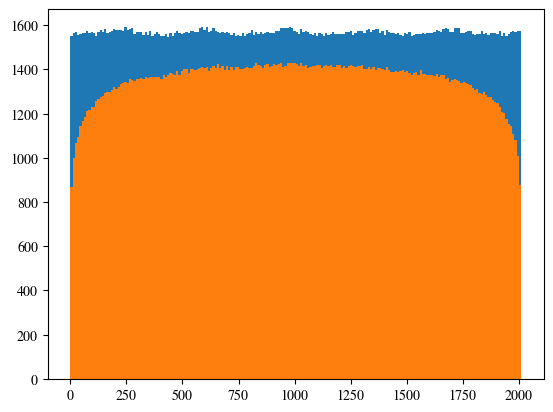

In [10]:
plt.hist(tot['t0lens1'],range=[0,2010],bins=200,weights=tot['fwc'])
plt.hist(tot['tcroin'],range=[0,2010],bins=200,weights=tot['fwc'])
plt.show()

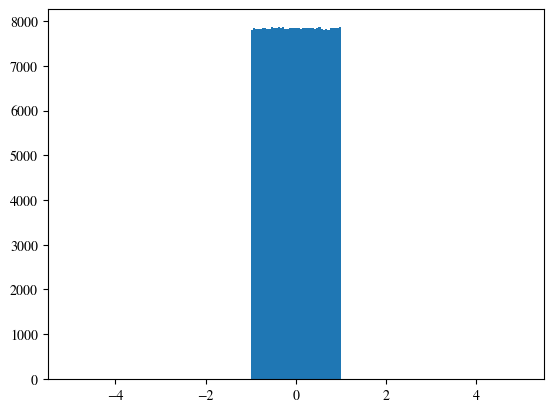

In [11]:
plt.hist(tot['u0lens1'],range=[-5,5],bins=200,weights=tot['fwc'])
plt.show()

In [12]:
# Get the total number of events
corrected_total_events = np.sum(dat['final_weight'])
print(corrected_total_events)

31680.162493718675


In [13]:
# build histograms for mass-SMA
dat_eff = np.histogram2d(np.log10(dat['Planet_semimajoraxis']),np.log10(dat['Planet_mass']/mearth),bins=[a_bins,m_bins],
                          weights=dat['fwc'])     
det_eff = np.histogram2d(np.log10(det['Planet_semimajoraxis']),np.log10(det['Planet_mass']/mearth),bins=[a_bins,m_bins],
                          weights=det['fwc'])     

/tmp/slurmtmp.8740314/ipykernel_3322162/1418509172.py:6: RuntimeWarning: divide by zero encountered in log10
  phist = np.log10(det_efficiency).T


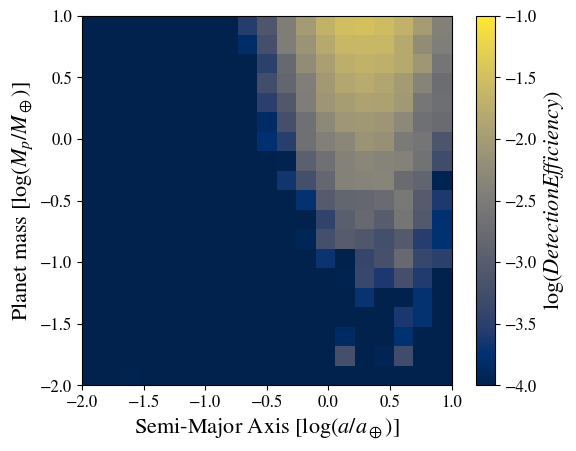

In [14]:
# compute the detection sensitivity in terms of mass-SMA. 
det_efficiency = det_eff[0]/dat_eff[0] 
survey_sensitivity = det_efficiency * corrected_total_events
if True:        
    fig,ax = plt.subplots()
    phist = np.log10(det_efficiency).T
    #phist = np.log10(det_eff).T
    phist = np.clip(phist,-4,None)
    im = ax.imshow(phist,origin='lower',extent=[np.log10(a_low),np.log10(a_high),np.log10(m_low),np.log10(m_high)],vmin=-4,vmax=-1,cmap='cividis')
    #ax.scatter(np.log10(planet_sample['Planet_semimajoraxis']),np.log10(planet_sample['Planet_mass']/mearth),c=np.log10(planet_sample['sensitivity']/corrected_total_events),vmin=-4,vmax=-1,cmap='cividis')
    ax.set_xlabel(r'Semi-Major Axis [$\log(a/a_\oplus)$]',fontsize=16)
    ax.set_ylabel(r'Planet mass [$\log(M_p/M_\oplus)$]',fontsize=16)
    #plt.colorbar(im,label=r'$\log (N_{det})$ if each lens has one planet at $(M,a)$')
    cb = plt.colorbar(im,label=r'$\log ({Detection Efficiency})$')
    cb.set_label(label=r'$\log ({Detection Efficiency})$', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    cb.ax.tick_params(labelsize=12)
    plt.savefig('ma_map.pdf')

/tmp/slurmtmp.8740314/ipykernel_3322162/1871045696.py:16: RuntimeWarning: divide by zero encountered in log10
  phist = np.log10(efficiency_insol).T#[:,::-1]


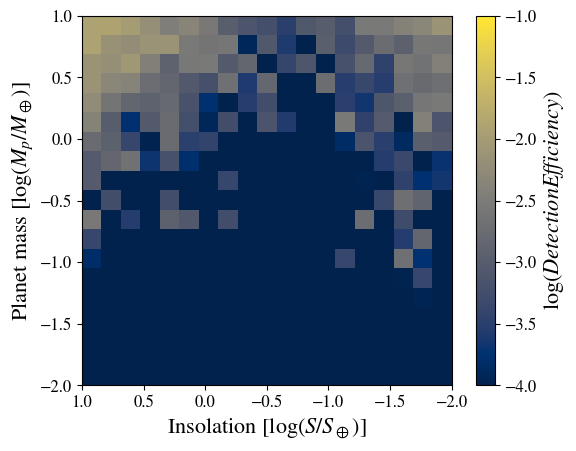

In [15]:
# build histograms for mass-insolation
s_low, s_high = 0.01, 10
s_bins = np.linspace(np.log10(s_low),np.log10(s_high),nbins,endpoint=True)
dat_eff_insol = np.histogram2d(np.log10(dat['Planet_insolation']),np.log10(dat['Planet_mass']/mearth),bins=[s_bins,m_bins],weights=dat['final_weight'])     
det_eff_insol = np.histogram2d(np.log10(det['Planet_insolation']),np.log10(det['Planet_mass']/mearth),bins=[s_bins,m_bins],weights=det['final_weight'])#/det_uniform[:,50]*3)#/det_uniform[:,50])

# detection efficiency in mass-insolation space     
efficiency_insol = det_eff_insol[0]/dat_eff_insol[0]
# survey sensitivity in mass-SMA space   
s_survey_sensitivity = efficiency_insol * corrected_total_events

s_bin_centers = (s_bins[1:]+s_bins[:-1])/2
m_bin_centers = (m_bins[1:]+m_bins[:-1])/2
test = 1#occ_arr(true_parameters,a_bin_centers,m_bin_centers)
fig,ax = plt.subplots()
phist = np.log10(efficiency_insol).T#[:,::-1]
phist = np.clip(phist,-5,None)
im = ax.imshow(phist,origin='lower',extent=[np.log10(s_high),np.log10(s_low),np.log10(m_low),np.log10(m_high)],vmin=-4,vmax=-1,cmap='cividis')
#ax.scatter(np.log10(planet_sample[:,43]),np.log10(planet_sample[:,42]/mearth),c=np.log10(planet_sample[:,0]),vmin=-4,vmax=2,cmap='cividis')  
ax.set_xlabel(r'Insolation [$\log(S/S_\oplus)$]',fontsize=16)
ax.set_ylabel(r'Planet mass [$\log(M_p/M_\oplus)$]',fontsize=16)
cb = plt.colorbar(im,label=r'$\log ({Detection Efficiency})$')
cb.set_label(label=r'$\log ({Detection Efficiency})$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
cb.ax.tick_params(labelsize=12)
plt.savefig('ms_map.pdf')


In [16]:
det_hist = np.histogram(np.log10(det['Planet_mass']/mearth),bins=m_bins,weights=det['fwc'])

In [17]:
det_hist[0]

array([ 0.05476764,  0.27029432,  0.10063701,  0.11163519,  0.15077024,
        0.33513537,  0.7068122 ,  0.83286857,  1.43670399,  1.84264488,
        3.35712462,  4.2943674 ,  5.78544942,  7.77331711, 11.30759032,
       13.99050355, 19.20021137, 23.36225181, 30.17258706])

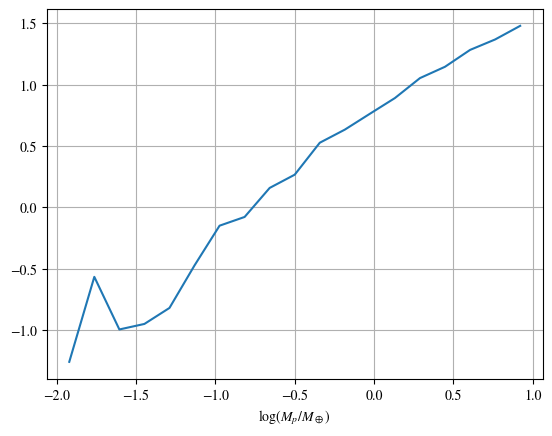

In [18]:
plt.plot(m_bin_centers,np.log10(det_hist[0]),label='Detections')
plt.xlabel(r"$\log(M_p/M_\oplus)$")
plt.grid()

462.38164310457506


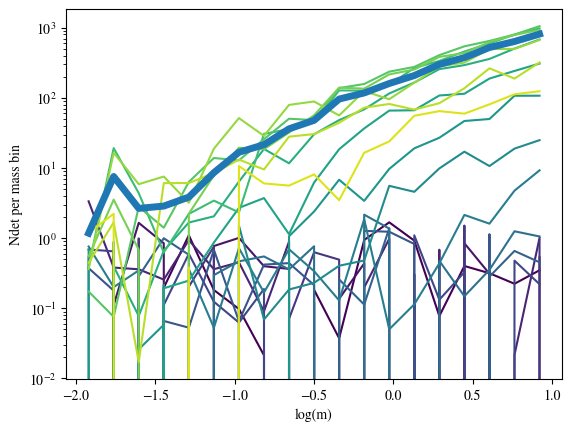

Total Events  31680.162493718675


In [19]:
cmap = plt.get_cmap('viridis')
mass_sens = scipy.integrate.simpson(survey_sensitivity,dx=a_bins[1]-a_bins[0],axis=0)
tot_sens = scipy.integrate.simpson(mass_sens,dx=a_bins[1]-a_bins[0],axis=0)
print(tot_sens)

fig, ax = plt.subplots()

# Plot lines with sequential colors
for i, y in enumerate(m_bin_centers):
    ax.plot(m_bin_centers, survey_sensitivity[i,:], color=cmap(i / len(m_bin_centers)))
    
ax.plot(m_bin_centers,mass_sens,linewidth=5)

plt.ylabel('Ndet per mass bin')
plt.yscale('log')
plt.xlabel('log(m)')
plt.show()
print('Total Events ', corrected_total_events)

In [20]:
#make copies just in case   
dat_real = dat.copy()
det_real = det.copy()

#for full functional fitting of broken power law with varying break point in mass
#define injected occurrence rate parameters    
logC1_true = np.log10(2)
logMS1_true = 1
n1_true = 0
#logMbreak_true = np.log10(5.2)     
Mbreak_true = (5.2)
logC2_true = np.log10(2)
logMS2_true = np.log10(95)
n2_true = -0.73
m_true = 0

#set up as a dictionary    
true_parameters = {'logC1':logC1_true,
                   'logMS1':logMS1_true,
                   'n1':n1_true,
                   'logMbreak':np.log10(Mbreak_true),
                   'logC2':logC2_true,
                   'logMS2':logMS2_true,
                   'n2':n2_true,
                   'm':m_true}


#simplified version 
n_true = -1
m_true =0
logC_true = np.log10(2)    



#set up as a dictionary    
true_params = {'logC':logC_true,
               'n':n_true,
               'm':m_true}




In [21]:
### draw planet sample    
#using cassan weights, currently in -2 (or -8 for uctc altered file)      
# new: where is -2 coming from???     
#new weights = raww * 3 * 3 * (occurrence rate value) 
#the 3's come from normalizing to the injected distribution of planets   
det['fwc'] = 9*det['final_weight']*mass_func_arr(true_params,det)
print("Expected total detections:",np.sum(det['fwc']))
#draw a sample          
planet_temp = draw_sample(det,weight_col='fwc')
#copy just in case? Not sure  
planet_sample = planet_temp.copy()
#retrieve the individual senstivity values for the sample of planets      
planet_sample['sensitivity'] =  get_2dhist_values(survey_sensitivity,planet_sample,a_bins,m_bins)
print("Actual sample size:", planet_sample.shape[0])

Expected total detections: 953.78942559785
Actual sample size: 968


In [22]:
np.sum(det['fwc'])/np.sum(det['final_weight'])
print(np.sum(9*det['final_weight']*mass_func_arr(true_params,det)))
print(np.sum(det['fwc']))

953.78942559785
953.78942559785


In [23]:
## fitting the sample  
params = lmfit.Parameters()
n_value = 0

#some more or less random values at this point. Boundaries are fairly lenient.
# boolean for each paramater determines if that parameter is varied 
params.add_many(('logC',np.log10(1),True,0,3),
                ('n',n_value,True,-5,5),
                ('m',0,True,-5,5))

# run the MLE fit 
#survey_sensitivity = np.nan_to_num(survey_sensitivity,nan=0)
#res = lmfit.minimize(ln_like_neg, params, args=(planet_sample,det_real),method='Nelder')#,bounds=bounds)#,callback=callbackF) 
#res = lmfit.minimize(ln_like_neg, params, args=(planet_sample,survey_sensitivity),method='Nelder')#,bounds=bounds)#,callback=callbackF) 
res = lmfit.minimize(ln_like_neg, params, args=(planet_sample,survey_sensitivity),method='Nelder')#,bounds=bounds)#,callback=callbackF) 

# essentially formatting   
occ_arr_res = occ_arr(res.params,a_bin_centers,m_bin_centers)
det_yield = (occ_arr_res*survey_sensitivity)
#print(occ_arr_res)
# integrate the occurrence rates  
#int1 = scipy.integrate.simpson([scipy.integrate.simpson(zz_x,x=a_bin_centers) for zz_x in occ_arr_res.T*survey_sensitivity],x=m_bin_centers)
inner_int = np.array([scipy.integrate.simpson(row,x=a_bin_centers) for row in det_yield])
outer_int = scipy.integrate.simpson(inner_int,x=m_bin_centers)
int1 = N_exp_real(res.params, planet_sample, survey_sensitivity)
print("N_exp from fit: ", outer_int, int1)

N_exp from fit:  968.0690398100909 968.0690398100909


In [24]:
print(10**res.params['logC'], res.params['n'].value, res.params['m'].value)

1.8153856049882877 -1.0128328979409251 0.20449781291376645


1


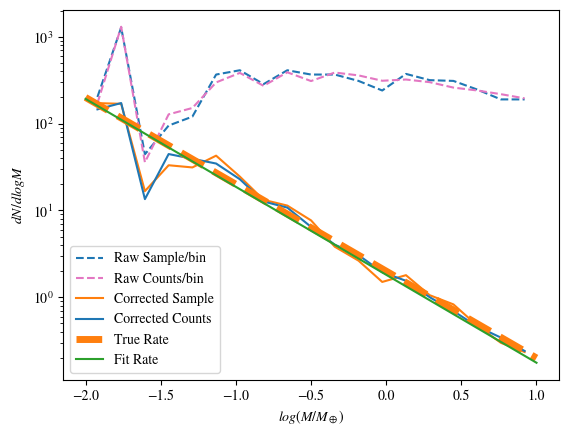

In [25]:
# survey_sensitivity integrated over semi-major axis (a) 
mass_sens = scipy.integrate.simpson(survey_sensitivity,dx=a_bins[1]-a_bins[0],axis=0)
#mass_sens = scipy.integrate.simpson(det_efficiency.T,dx=a_bins[1]-a_bins[0],axis=1)

# plot the results of the LME     
m_bin_centers = (m_bins[:-1]+m_bins[1:])/2
# build mass histograms, relevant vars  
hist,bins = np.histogram(np.log10(planet_sample['Planet_mass']/mearth),bins=m_bins)
hist_true,bins = np.histogram(np.log10(det['Planet_mass']/mearth),bins=m_bins,weights=det['fwc'])

# histograms of full sim results  
# THIS LINE WAS RECENTLY HAD LAST COMMENT ADDED 
massw,bins = np.histogram(np.log10(dat['Planet_mass']/mearth),bins=m_bins,weights=dat['fwc'])
massd = np.histogram(np.log10(det['Planet_mass']/mearth),bins=m_bins,weights=det['fwc'])[0]

# I don't think this is needed
sma_sens = np.histogram(np.log10(det['Planet_semimajoraxis']),bins=a_bins,weights=det['fwc'])[0]/np.histogram(np.log10(dat['Planet_semimajoraxis']),bins=a_bins,weights=dat['fwc'])[0]
m_points = np.linspace(-2,1,1000)  

# plot mass
fig,ax = plt.subplots()

# could be needed for normalization, need to actually plug in real integral form
sma_int = 1 #(a_high**res.params['m'] - a_low**res.params['m']) / res.params['m'] / np.log(10) / 3
print(sma_int)


# plot uncorrected counts (units are counts per bin width)   
ax.semilogy(m_bin_centers, hist/(m_bins[1]-m_bins[0]),'C0--',label='Raw Sample/bin')#*(m_bins[1]-m_bins[0]))                                                                                                  
# plot true counts per bin width     
ax.semilogy(m_bin_centers,( hist_true/(m_bins[1]-m_bins[0])),'C6--',label='Raw Counts/bin')#*(m_bins[1]-m_bins[0]))
# calculate the corrected corrected observed counts  
corr = hist  / mass_sens / sma_int / (m_bins[1]-m_bins[0]) #/corr_fac                                                                                                                                               
# calculate the true injected mass function  
true_x = mass_func_arr(true_params,m_bin_centers)
# calculate the corrected true counts                                                                                                                                                                     
corr1 = hist_true / mass_sens / sma_int / (m_bins[1]-m_bins[0]) #/ corr_fac                                                                                                                                         
# plot true counts                   
ax.semilogy(m_bin_centers, corr,'C1',label='Corrected Sample')
ax.semilogy(m_bin_centers, corr1,'C0',label='Corrected Counts')
# Plot the true mass function   
ax.semilogy(m_points,mass_func_arr(true_params,m_points),'C1--',linewidth=5,label='True Rate')
ax.semilogy(m_points,mass_func_arr(res.params,m_points),'C2',label='Fit Rate')
#ax.semilogy(m_bin_centers,2/(hist_true/(m_bins[1]-m_bins[0])),'k',label='Required for Corr')
# plot mass sens
#ax.semilogy(m_bin_centers, 1/mass_sens,'C4--',label='1/Mass Sens')
# plot fitted function
#ax.semilogy(m_points,mass_func_plot(res.params,m_points),'C2',label='Fit')
ax.set_xlabel(r'$log(M/M_\oplus)$')
ax.set_ylabel(r'$dN/dlogM$')
plt.legend()
#ax.semilogy(m_points,mass_func(start,m_points))  
#ax.semilogy(m_points,mass_func(res.x,m_points)) 
plt.show()

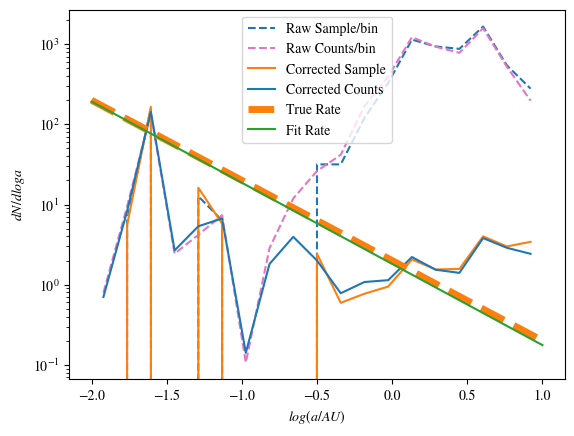

In [26]:
# this should be analagous plot for SMA distribution, some testing and figuring needs to be done still
# first of all should not be using mass_func_arr(), need a new version
# maybe should be evaluating for fixed mass or SMA?

# survey_sensitivity integrated over semi-major axis (a) 
sma_sens = scipy.integrate.simpson(survey_sensitivity.T,dx=m_bins[1]-m_bins[0],axis=0)
#mass_sens = scipy.integrate.simpson(det_efficiency.T,dx=a_bins[1]-a_bins[0],axis=1)

# plot the results of the LME     
a_bin_centers = (a_bins[:-1]+a_bins[1:])/2
# build mass histograms, relevant vars  
hist,bins = np.histogram(np.log10(planet_sample['Planet_semimajoraxis']),bins=a_bins)
hist_true,bins = np.histogram(np.log10(det['Planet_semimajoraxis']),bins=a_bins,weights=det['fwc'])

# histograms of full sim results  
# THIS LINE WAS RECENTLY HAD LAST COMMENT ADDED 
smaw, bins = np.histogram(np.log10(dat['Planet_semimajoraxis']),bins=a_bins,weights=dat['fwc'])
smad, bins = np.histogram(np.log10(det['Planet_semimajoraxis']),bins=a_bins,weights=det['fwc'])

#plot x points
sma_points = np.linspace(-2,1,1000)  

# plot mass
fig,ax = plt.subplots()



# plot uncorrected counts (units are counts per bin width)   
ax.semilogy(a_bin_centers, hist/(a_bins[1]-a_bins[0]),'C0--',label='Raw Sample/bin')#*(m_bins[1]-m_bins[0]))                                                                                                  
# plot true counts per bin width     
ax.semilogy(a_bin_centers,( hist_true/(a_bins[1]-a_bins[0])),'C6--',label='Raw Counts/bin')#*(m_bins[1]-m_bins[0]))
# calculate the corrected corrected observed counts  
corr = hist  / sma_sens / (a_bins[1]-a_bins[0]) #/corr_fac                                                                                                                                               
# calculate the true injected mass function  
true_x = mass_func_arr(true_params,a_bin_centers)
# calculate the corrected true counts                                                                                                                                                                     
corr1 = hist_true / sma_sens / (a_bins[1]-a_bins[0]) #/ corr_fac                                                                                                                                         
# plot true counts                   
ax.semilogy(a_bin_centers, corr,'C1',label='Corrected Sample')
ax.semilogy(a_bin_centers, corr1,'C0',label='Corrected Counts')
# Plot the true mass function   
ax.semilogy(sma_points,mass_func_arr(true_params,sma_points),'C1--',linewidth=5,label='True Rate')
ax.semilogy(sma_points,mass_func_arr(res.params,sma_points),'C2',label='Fit Rate')
#ax.semilogy(m_bin_centers,2/(hist_true/(m_bins[1]-m_bins[0])),'k',label='Required for Corr')
# plot mass sens
#ax.semilogy(m_bin_centers, 1/mass_sens,'C4--',label='1/Mass Sens')
# plot fitted function
#ax.semilogy(m_points,mass_func_plot(res.params,m_points),'C2',label='Fit')
ax.set_xlabel(r'$log(a/AU)$')
ax.set_ylabel(r'$dN/dloga$')
plt.legend()
#ax.semilogy(m_points,mass_func(start,m_points))  
#ax.semilogy(m_points,mass_func(res.x,m_points)) 
plt.show()

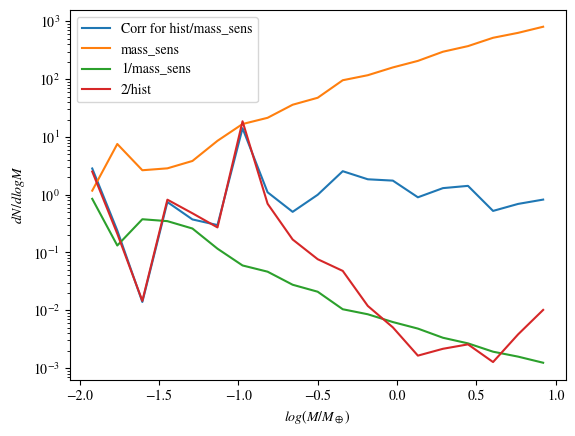

In [27]:
#just some diagnostic plots when I was trying to figure out what was going on with corrections

#mass_sens = scipy.integrate.simpson(survey_sensitivity,dx=a_bins[1]-a_bins[0],axis=0)
fig,ax = plt.subplots()
ax.semilogy(m_bin_centers,2/corr1, label='Corr for hist/mass_sens')
ax.semilogy(m_bin_centers,mass_sens, label='mass_sens')
ax.semilogy(m_bin_centers,1/mass_sens,label='1/mass_sens')
ax.semilogy(m_bin_centers,2/( hist_true/(m_bins[1]-m_bins[0])),label='2/hist')
ax.set_xlabel(r'$log(M/M_\oplus)$')
ax.set_ylabel(r'$dN/dlogM$')
plt.legend()
#ax.semilogy(m_points,mass_func(start,m_points))  
#ax.semilogy(m_points,mass_func(res.x,m_points)) 
plt.show()

In [28]:
#### MCMC ####
# Was set up for iterative redraws of planet sample, keeping some of the framework for that
i = 0
filename = "mcmc_"+str(i)+".par4.nomaglim.invsens.h5"
n_walkers = 15
n_steps = 1000
n_burn = 100

#set-up
logC_start = res.params['logC']
n_start = res.params['n']
m_start = res.params['m']

starting_mean = np.array([logC_start,n_start,m_start])
starting_sigma = 0.01*np.ones(len(starting_mean))
starting = [(starting_mean + starting_sigma * np.random.randn(len(starting_mean))) for i in range(n_walkers)]

index = 0
autocorr = np.empty(n_steps)
old_tau = np.inf

In [29]:
print('starting')

# delete old file, can be removed if you want to stack MCMC runs
os.remove("data_penny/"+filename)

backend = emcee.backends.HDFBackend("data_penny/"+filename)

n_parameters = len(starting_mean)

sampler = emcee.EnsembleSampler(n_walkers, n_parameters, ln_prob, args=(planet_sample, survey_sensitivity),backend=backend)

starting


In [30]:
start = timeit.default_timer()
for sample in sampler.sample(starting, iterations=n_steps,progress=False):
    #print(sampler.iteration)
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    #ipdb.set_trace()
    print('Checking autocorr time at step: ',sampler.iteration)
    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 50 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    print('ACT at iter: '+str(autocorr[index-1]) +' at ' +str(int(sampler.iteration)))
    if converged:
        break
    old_tau = tau

stop = timeit.default_timer()

Checking autocorr time at step:  100
ACT at iter: 8.117393779976512 at 100
Checking autocorr time at step:  200
ACT at iter: 13.117331944727475 at 200
Checking autocorr time at step:  300
ACT at iter: 18.00643274353081 at 300
Checking autocorr time at step:  400
ACT at iter: 19.14839638581556 at 400
Checking autocorr time at step:  500
ACT at iter: 23.00831127589403 at 500
Checking autocorr time at step:  600
ACT at iter: 25.5944292181435 at 600
Checking autocorr time at step:  700
ACT at iter: 25.38911293186717 at 700
Checking autocorr time at step:  800
ACT at iter: 25.854668986798202 at 800
Checking autocorr time at step:  900
ACT at iter: 26.104665118811976 at 900
Checking autocorr time at step:  1000
ACT at iter: 27.720347498773055 at 1000


Completed after  1000  samples in  0.011527339476160704  hours.


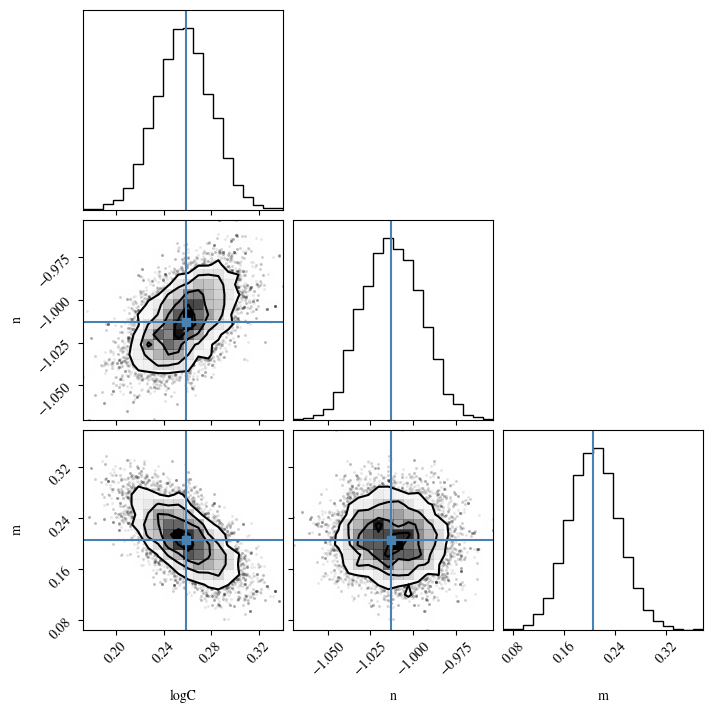

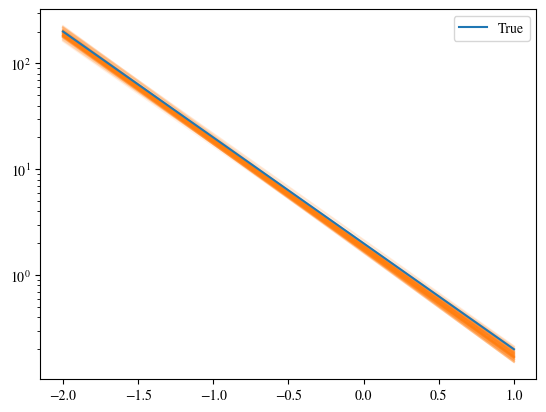

In [31]:
#### Corner Plot ####

print('Completed after ', sampler.iteration, ' samples in ',(stop-start)/60/60 ,' hours.')
flat_samples = sampler.get_chain(discard=n_burn, flat=True)
# make sure this matches the labels of parameters you want to plot
labels = ['logC','n','m']#,'m']
fig = corner.corner(flat_samples, labels=labels, truths=starting_mean)
plt.show()

fig,ax = plt.subplots()
ax.semilogy(m_points,mass_func_arr(true_params,m_points),label='True',zorder=10000)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(sample)
    ax.semilogy(m_points,mass_func_arr(sample,m_points),'C1',alpha=0.1)
    #plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.legend()
plt.show()